In [65]:
import yfinance as yf
import pandas as pd
import numpy as np
import os

Load Data

In [66]:
from utils.loader import load_data_with_logReturn

data_clean = load_data_with_logReturn("test_stocks/AAPL.csv")

Train/Val/Test Split

Here the Train and Val follows the proportial of 8:2 from historical data uptill 2024-12-31 and Test is fixed value from 2025-01-01 to 2025-05-02

In [67]:
features = [
        "Open", "High", "Low", "Close", "Volume",
        "LogReturn_Lag1", "LogReturn_Lag2", "LogReturn_Lag3", "LogReturn_Lag4", "LogReturn_Lag5"
    ]
target = "LogReturn"

X = data_clean[features]
y = data_clean[target]

from datetime import datetime


split_date = pd.Timestamp("2023-12-31")
test_start = pd.Timestamp("2024-01-01")
test_end = pd.Timestamp("2025-05-02")

X_all = X.loc[:split_date]
y_all = y.loc[:split_date]

n = len(X_all)
split_idx = int(n * 0.8)

X_train = X_all.iloc[:split_idx]
y_train = y_all.iloc[:split_idx]
X_val = X_all.iloc[split_idx:]
y_val = y_all.iloc[split_idx:]

X_test = X.loc[test_start:test_end]
y_test = y.loc[test_start:test_end]

In [68]:
def print_data_summary(X_train, y_train, X_val, y_val, X_test, y_test):
    print("----- DATA SUMMARY -----")
    for name, X, y in [("Train", X_train, y_train), ("Validation", X_val, y_val), ("Test", X_test, y_test)]:
        print(f"{name} Features Shape: {X.shape}, Target Shape: {y.shape}")
    print("\nFeature Names:", X_train.columns.tolist())

print_data_summary(X_train, y_train, X_val, y_val, X_test, y_test)

----- DATA SUMMARY -----
Train Features Shape: (8677, 10), Target Shape: (8677,)
Validation Features Shape: (2170, 10), Target Shape: (2170,)
Test Features Shape: (335, 10), Target Shape: (335,)

Feature Names: ['Open', 'High', 'Low', 'Close', 'Volume', 'LogReturn_Lag1', 'LogReturn_Lag2', 'LogReturn_Lag3', 'LogReturn_Lag4', 'LogReturn_Lag5']


Define the FIR Model

![FIR Diagram](FIR_filter.png)

In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # ravel to flatten

fir_model = LinearRegression()
fir_model.fit(X_train_scaled, y_train_scaled)

y_train_pred_scaled = fir_model.predict(X_train_scaled)
y_val_pred_scaled = fir_model.predict(X_val_scaled)
y_test_pred_scaled = fir_model.predict(X_test_scaled)

y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

In [70]:
print("Validation R²:", r2_score(y_val, y_val_pred))
print("Validation RMSE:", root_mean_squared_error(y_val, y_val_pred))
print("Test R²:", r2_score(y_test, y_test_pred))
print("Test RMSE:", root_mean_squared_error(y_test, y_test_pred))


Validation R²: -41.12723488069958
Validation RMSE: 0.11941330976881571
Test R²: -192.0631649018064
Test RMSE: 0.2634134708862684


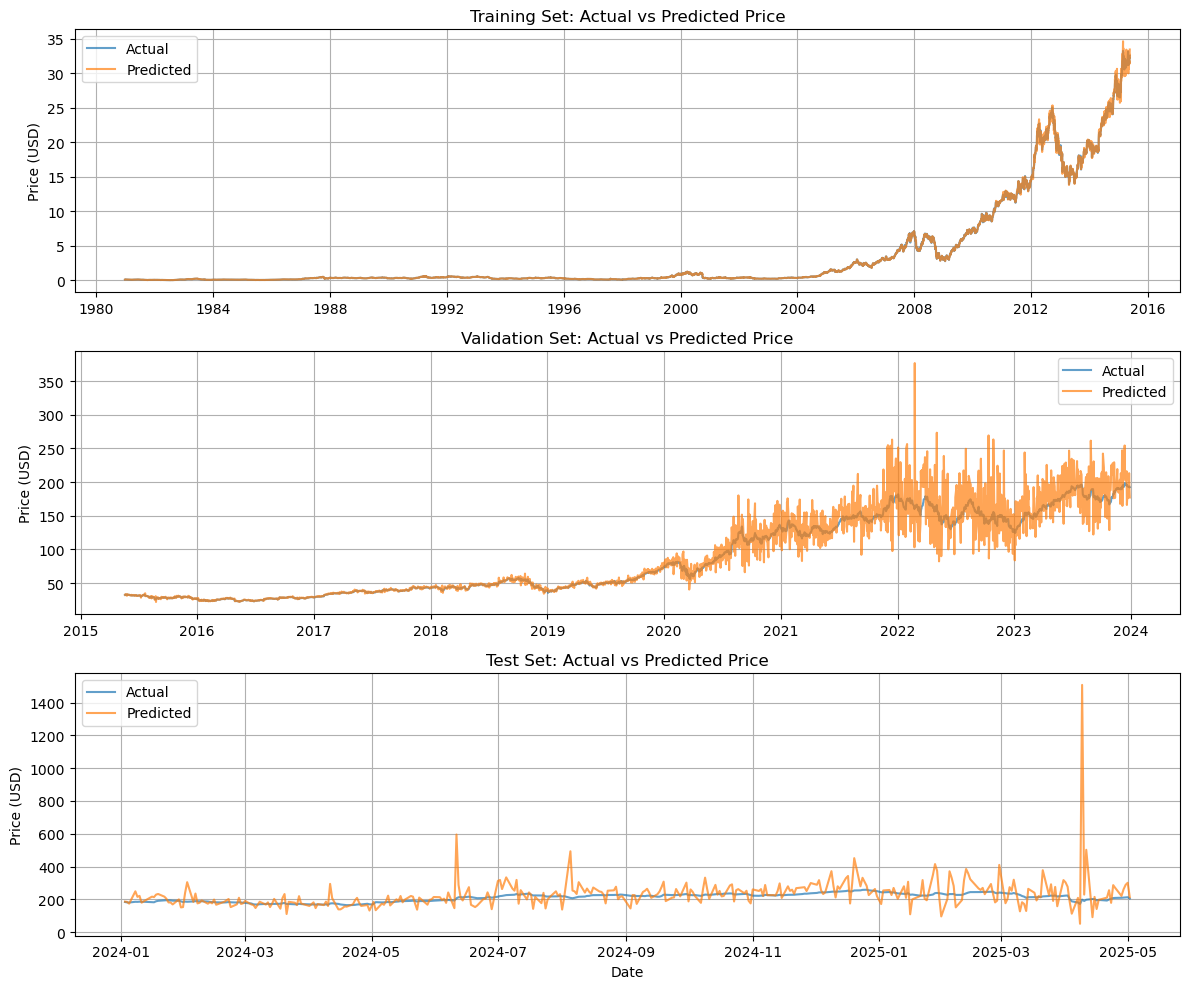

In [71]:
from utils.plotter import plot_actual_vs_predicted_prices

plot_actual_vs_predicted_prices(
    X_train, y_train, y_train_pred,
    X_val, y_val, y_val_pred,
    X_test, y_test, y_test_pred
)


Traiding Strategy

In [72]:
from utils.eval import evaluate_strategy_performance,calculate_average_pnl

returns, capital, test_positions = evaluate_strategy_performance(
            y_val,
            y_val_pred,
            y_test,
            y_test_pred
        )

pnl_result = calculate_average_pnl(test_positions, y_test)

In [73]:
summary = {
            "Val Return": returns["Validation Cumulative Return"],
            "Val Sharpe": returns["Validation Sharpe Ratio"],
            "Test Return": returns["Test Cumulative Return"],
            "Test Sharpe": returns["Test Sharpe Ratio"],
            "Final Val Capital": capital["Final Val Capital"],
            "Final Test Capital": capital["Final Test Capital"],
            "Average PnL": pnl_result["average_pnl"],
            "Average PnL (%)": pnl_result["average_pnl_percent"]
        }

In [74]:
summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['Value'])
display(summary_df)

,Value
Val Return,8.296847e+09
Val Sharpe,1.107436e+01
Test Return,1.655747e+01
Test Sharpe,8.025359e+00
Final Val Capital,8.296847e+15
Final Test Capital,1.755747e+07
Average PnL,8.736313e+03
Average PnL (%),8.736313e-01


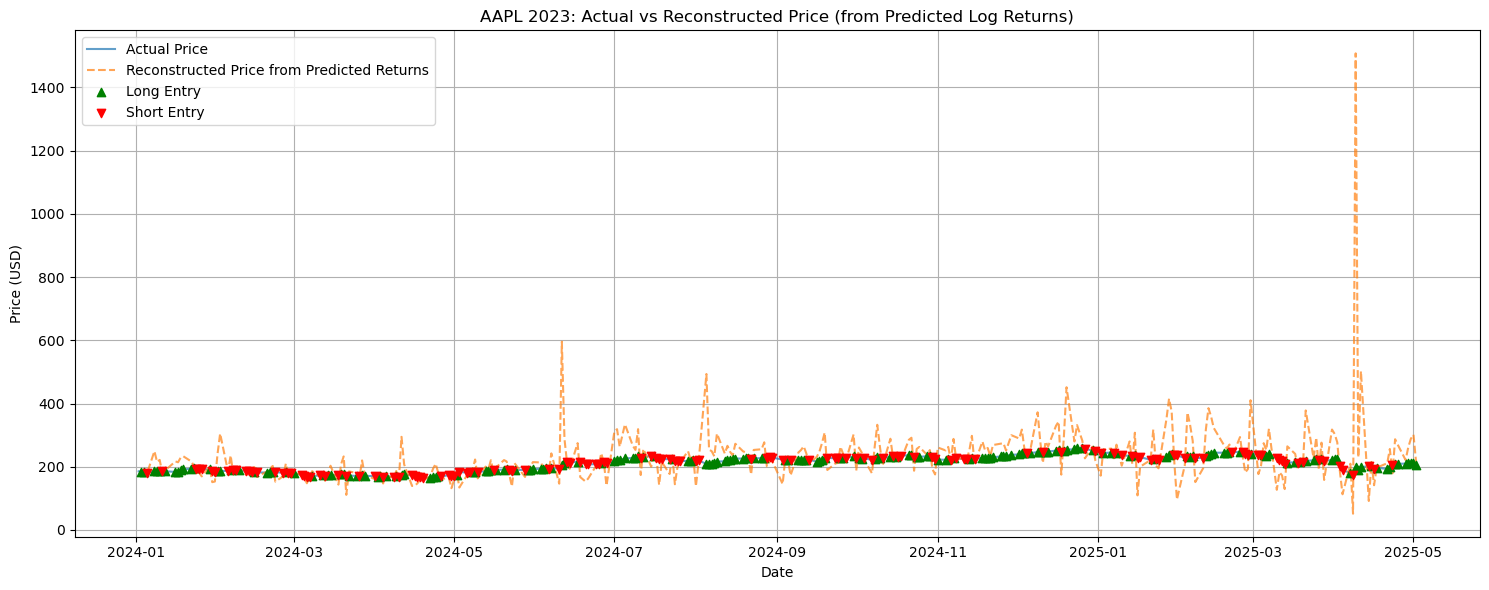

In [75]:
import matplotlib.pyplot as plt

# Long/Short markers
long_signals = (test_positions == 1)
short_signals = (test_positions == -1)

# Get dates
test_dates = y_test.index
plot_dates = test_dates[1:] 

# Assume: prices is the actual price series for test window (2023)
P_t = X_test.Close[:-1]              # P_t for days 0 to N-2
r_hat_t_plus_1 = y_test_pred[1:]      # predicted log return for days 1 to N-1
P_hat_t_plus_1 = P_t * np.exp(r_hat_t_plus_1)  # predicted P_{t+1}


# Plot
plt.figure(figsize=(15, 6))
plt.plot(test_dates, X_test.Close, label="Actual Price", alpha=0.7)
plt.plot(plot_dates, P_hat_t_plus_1, label="Reconstructed Price from Predicted Returns", linestyle="--", alpha=0.7)

plt.scatter(plot_dates[long_signals[1:]], X_test.Close.values[1:][long_signals[1:]], marker='^', color='green', label='Long Entry', zorder=5)
plt.scatter(plot_dates[short_signals[1:]], X_test.Close.values[1:][short_signals[1:]], marker='v', color='red', label='Short Entry', zorder=5)

plt.title("AAPL 2023: Actual vs Reconstructed Price (from Predicted Log Returns)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()